In [1]:
import os 
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
data_path = "/kaggle/input/cassava-leaf-disease-classification"
train_img_path = os.path.join(data_path, "train_images")
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Train data Num: 21397
Each label Num: 
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


<Axes: >

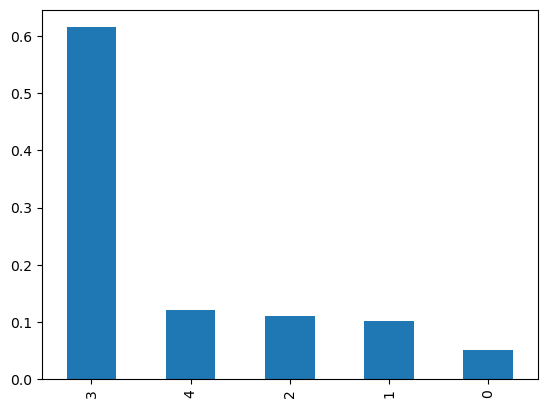

In [3]:
# EDA
print('Train data Num: {}'.format(len(train_df)))
print("Each label Num: ")
print(train_df["label"].value_counts()/len(train_df))
(train_df['label'].value_counts()/len(train_df)).plot(kind='bar')

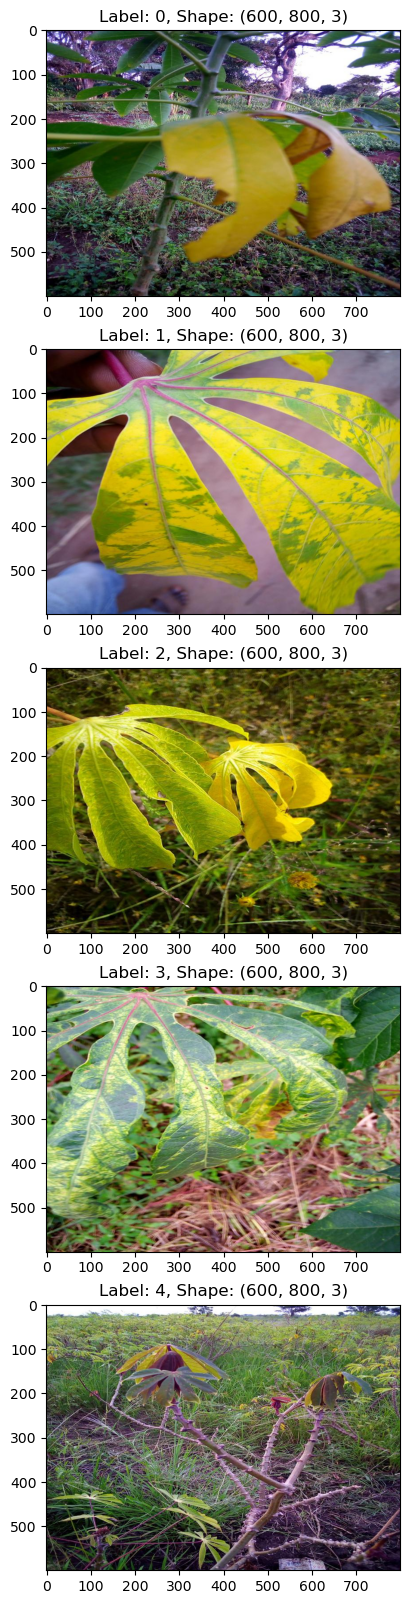

In [4]:
# plot images
def plot_images(df, data_path, figsize=(30,20)):
    label_len = len(df['label'].unique())
    fig = plt.figure(figsize=figsize)
    
    for i in range(label_len):
        ax = fig.add_subplot(label_len, 1, i+1)
        sample = df[df['label']==i]['image_id'].sample().reset_index(drop=True).iloc[0]
        sample = cv2.imread(os.path.join(data_path, sample))
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        
        plt.imshow(sample)
        plt.title('Label: {}, Shape: {}'.format(i, sample.shape))
    plt.show()
        
plot_images(train_df, train_img_path)

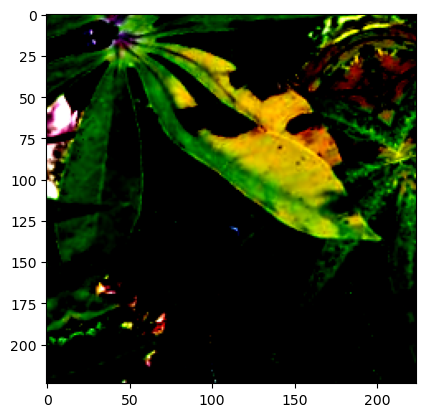

In [5]:
# create Dataset and Transform
class CassavaDataset(nn.Module):
    def __init__(self, df:pd.DataFrame, data_img_path:str, phase:str='train', transform:object=None):
        self.df = df
        self.data_img_path = data_img_path
        self.phase = phase
        self.transform = transform
        
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        sample = cv2.imread(os.path.join(self.data_img_path, sample))
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            sample = self.transform(sample, self.phase)
            
        if self.phase == 'test':
            return sample
        
        label = self.df['label'].iloc[idx]
        
        return sample, label
    
    def __len__(self):
        return len(self.df)
    
class Transform(object):
    def __init__(self, scale_limit, crop_size, mean, std):
        self.transfomr = {
            'train':A.Compose([
                A.Resize(600, 600),
                A.RandomScale(scale_limit, p=1),
                A.RandomCrop(crop_size, crop_size, p=1),
                A.Normalize(mean, std),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(),
                ToTensorV2()
            ]),
            'val':A.Compose([
                A.Resize(600, 600),
                A.CenterCrop(crop_size,crop_size),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.Resize(600, 600),
                A.CenterCrop(crop_size, crop_size),
                A.Normalize(mean, std),
                ToTensorV2()
            ])
        }
        
    def __call__(self, img, phase):
        return self.transfomr[phase](image=img)['image']

scale_min, scale_max = 256/600, 480/600
scale_limit = [1-scale_min, scale_max-1]
crop_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = Transform(scale_limit, crop_size, mean, std)
dataset = CassavaDataset(train_df, train_img_path, 'train', transform)
img, label = dataset.__getitem__(0)
plt.imshow(img.numpy().transpose(1,2,0))
plt.show()

In [6]:
# create model
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, drop_rate):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate * 4, kernel_size=1, bias=False)
        self.norm2 = nn.BatchNorm2d(growth_rate * 4)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate * 4, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        x = torch.cat(x, 1)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.dropout(x)

        return x
    
class DenseBlock(nn.ModuleDict):
    def __init__(self, num_layers, in_channels, growth_rate, drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = DenseLayer(
                in_channels + i * growth_rate,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.add_module(f"denselayer{i + 1}", layer)

    def forward(self, x0):
        x = [x0]
        for name, layer in self.items():
            out = layer(x)
            x.append(out)

        return torch.cat(x, 1)
    
class TransitionLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.add_module("norm", nn.BatchNorm2d(in_channels))
        self.add_module("relu", nn.ReLU(inplace=True))
        self.add_module("conv", nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.add_module("pool", nn.AvgPool2d(kernel_size=2, stride=2))
        
class DenseNet(nn.Module):
    def __init__(self, growth_rate, block_config, drop_rate=0, num_classes=1000):
        super().__init__()

        # 最初の畳み込み層を追加する。
        self.features = nn.Sequential()
        self.features.add_module(
            "conv0", nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        )
        self.features.add_module("norm0", nn.BatchNorm2d(2 * growth_rate))
        self.features.add_module("relu0", nn.ReLU(inplace=True))
        self.features.add_module("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # Dense Block 及び Transition Layer を作成する。
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=in_channels,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.features.add_module(f"denseblock{i + 1}", block)

            in_channels = in_channels + num_layers * growth_rate
            if i != len(block_config) - 1:
                # 最後の Dense Block でない場合は、Transition Layer を追加する。
                trans = TransitionLayer(in_channels=in_channels, out_channels=in_channels // 2)
                self.features.add_module(f"transition{i + 1}", trans)
                in_channels = in_channels // 2

        self.features.add_module("norm5", nn.BatchNorm2d(in_channels))
        self.features.add_module("relu5", nn.ReLU(inplace=True))
        self.features.add_module("pool5", nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(in_channels, num_classes)

        # 重みを初期化する。
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x


def densenet121(**kwargs):
    return DenseNet(growth_rate=32, block_config=(6, 12, 24, 16))

model = densenet121(num_classes=5)

In [8]:
from tqdm.notebook import tqdm

def train_model(model, dtdl_dict, optimizer, criterion, device, epoch, scheduler):
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
        
    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch, epochs))
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dtdl_dict[phase]):
                model = model.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels)
            
            epoch_loss = running_loss / len(dtdl_dict[phase].dataset)
            epoch_acc = running_corrects / len(dtdl_dict[phase].dataset)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_densenet.pth')
                
            if phase == 'train' and scheduler != None:
                scheduler.step()
                
            print("{} Loss: {:4f}, Acc: {:4f}".format(phase, epoch_loss, epoch_acc))
        print()
        
    time_elapced = since - time.time()
    print("Total Train time: {}m {}s".format(time_elapced//60, time_elapced%60))
    print("Val best acc: {}".format(best_acc))

train, val = train_test_split(train_df, test_size=0.2, random_state=0, stratify=train_df['label'])
traindataset = CassavaDataset(train, train_img_path, 'train', transform)
valdataset = CassavaDataset(val, train_img_path, 'val', transform)
traindl = DataLoader(traindataset, shuffle=True, batch_size=16, num_workers=2)
valdl = DataLoader(valdataset, shuffle=False, batch_size=16, num_workers=2)
dtdl_dict = {'train':traindl, 'val':valdl}
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5
train_model(model, dtdl_dict, optimizer, criterion, device, epochs, scheduler)

Epoch: 0/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 1.024461, Acc: 0.627096


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss: 0.914309, Acc: 0.651636

Epoch: 1/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 0.970869, Acc: 0.638780


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss: 0.947396, Acc: 0.663318

Epoch: 2/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 0.933505, Acc: 0.652100


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss: 1.029961, Acc: 0.607243

Epoch: 3/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 0.914584, Acc: 0.661740


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss: 0.829966, Acc: 0.700935

Epoch: 4/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 0.882934, Acc: 0.672489


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss: 1.004454, Acc: 0.687617

Total Train time: -23.0m 59.79903244972229s
Val best acc: 0.7009345889091492


In [ ]:
model.load_state_dict(torch.load(os.path.join(data_path, 'baseline-densenet/best_densenet.pth')))
model = model.to(device)
model.eval()

test_img_path = os.path.join(data_path, 'test_images')
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
testdataset = CassavaDataset(test_df, test_img_path, 'test', transform)
test_dl = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=2)

predictions = []
for inputs in test_dl:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predictions.append(preds)
    
test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv')